In [1]:
!pip install imbalanced-learn transformers datasets
 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 1.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 5.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 52.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.2/301.2 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 67.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.0/774.0 kB 39.6 MB/s eta 0:00:00
   ━━

In [6]:
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
from transformers import Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import pipeline
import pandas as pd
import numpy as np
import torch
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer

classifier = pipeline('text-classification', model='distilbert-base-uncased-finetuned-sst-2-english')

In [7]:
df = pd.read_csv('/Users/sandundesilva/Documents/4th year/Research Project/UI/findMyFilm/flask-server/Models/final/Distilbert/Final_genre_merged - Final_movie_train.csv')

#convert the labels to numerical and then encode it
le = LabelEncoder()
df['genre'] = le.fit_transform(df['genre'])

train, validate, test = np.split(df.sample(frac=1, random_state=42), [int(.6*len(df)), int(.8*len(df))])

train = train.reset_index()[['subtitles','genre']]
test = test.reset_index()[['subtitles','genre']]
validate = validate.reset_index()[['subtitles','genre']]

#convert dataframes to hugging face dataset formate
train_dataset = Dataset.from_pandas(train)
test_dataset = Dataset.from_pandas(test)
validation_dataset = Dataset.from_pandas(validate)

dataset = DatasetDict()
dataset['train'] = train_dataset
dataset['test'] = test_dataset
dataset['validation'] = validation_dataset


In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['subtitles', 'genre'],
        num_rows: 8898
    })
    test: Dataset({
        features: ['subtitles', 'genre'],
        num_rows: 2967
    })
    validation: Dataset({
        features: ['subtitles', 'genre'],
        num_rows: 2966
    })
})

In [9]:
original_labels = le.classes_

for idx, label in enumerate(original_labels):
    print(f"Label {idx}: {label}")

label_map = {idx: label for idx, label in enumerate(original_labels)}

print(label_map)


Label 0: action
Label 1: adult
Label 2: adventure
Label 3: animation
Label 4: biography
Label 5: comedy
Label 6: crime
Label 7: documentary
Label 8: drama
Label 9: family
Label 10: fantasy
Label 11: game-show
Label 12: history
Label 13: horror
Label 14: music
Label 15: musical
Label 16: mystery
Label 17: news
Label 18: reality-tv
Label 19: romance
Label 20: sci-fi
Label 21: short
Label 22: sport
Label 23: talk-show
Label 24: thriller
Label 25: war
Label 26: western
{0: 'action', 1: 'adult', 2: 'adventure', 3: 'animation', 4: 'biography', 5: 'comedy', 6: 'crime', 7: 'documentary', 8: 'drama', 9: 'family', 10: 'fantasy', 11: 'game-show', 12: 'history', 13: 'horror', 14: 'music', 15: 'musical', 16: 'mystery', 17: 'news', 18: 'reality-tv', 19: 'romance', 20: 'sci-fi', 21: 'short', 22: 'sport', 23: 'talk-show', 24: 'thriller', 25: 'war', 26: 'western'}


In [ ]:
import re
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub("\s[\s]+", " ", text).strip()
    return text  

train_data['Text_cleaning'] = train_data['subtitles'].apply(clean_text)
test_data['Text_cleaning'] = test_data['subtitles'].apply(clean_text)

In [5]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [10]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModel.from_pretrained(model_ckpt).to(device)

print(model)


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [6]:
def tokenize(batch):
    return tokenizer(batch["subtitles"], padding=True, truncation=True)

In [7]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)


Map:   0%|          | 0/5715 [00:00<?, ? examples/s]

Map:   0%|          | 0/1905 [00:00<?, ? examples/s]

Map:   0%|          | 0/1905 [00:00<?, ? examples/s]

In [8]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [9]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [10]:
dataset_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])

In [11]:
dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/5715 [00:00<?, ? examples/s]

Map:   0%|          | 0/1905 [00:00<?, ? examples/s]

Map:   0%|          | 0/1905 [00:00<?, ? examples/s]

In [12]:
dataset_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [13]:
num_labels = 27
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_names = le.classes_

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    
    labels = [class_names[label] for label in labels]
    preds = [class_names[pred] for pred in preds]
    
    cm = confusion_matrix(labels, preds, labels=class_names)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    return {"accuracy": acc, "f1": f1, "labels": labels, "predictions": preds}


In [26]:
batch_size = 64
logging_steps = len(dataset_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=10,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, 
                                  log_level="error")

In [27]:

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=dataset_encoded["train"],
                  eval_dataset=dataset_encoded["validation"],
                  tokenizer=tokenizer)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


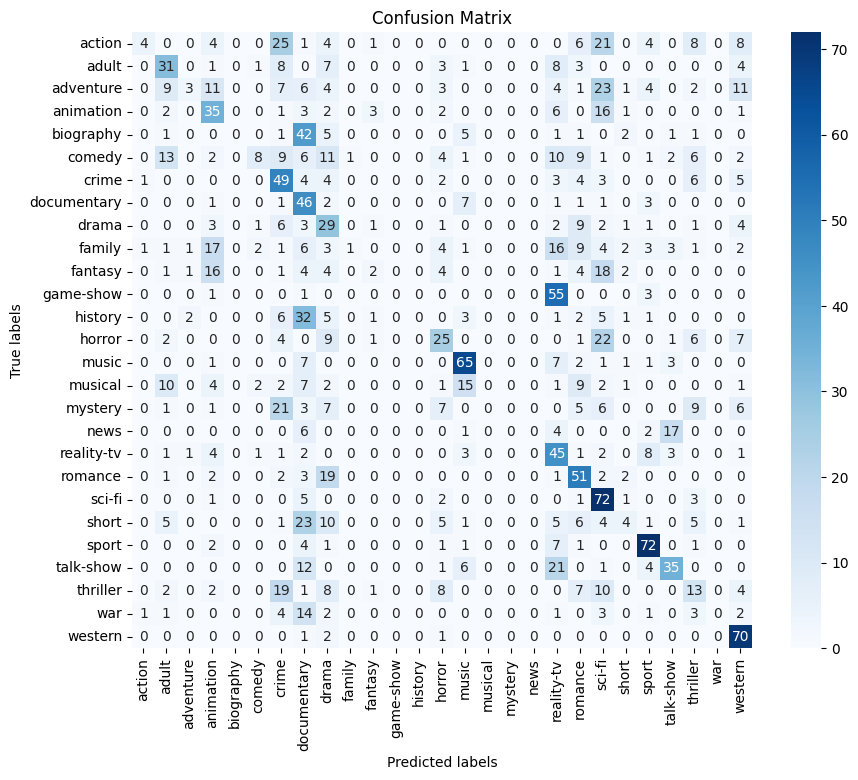

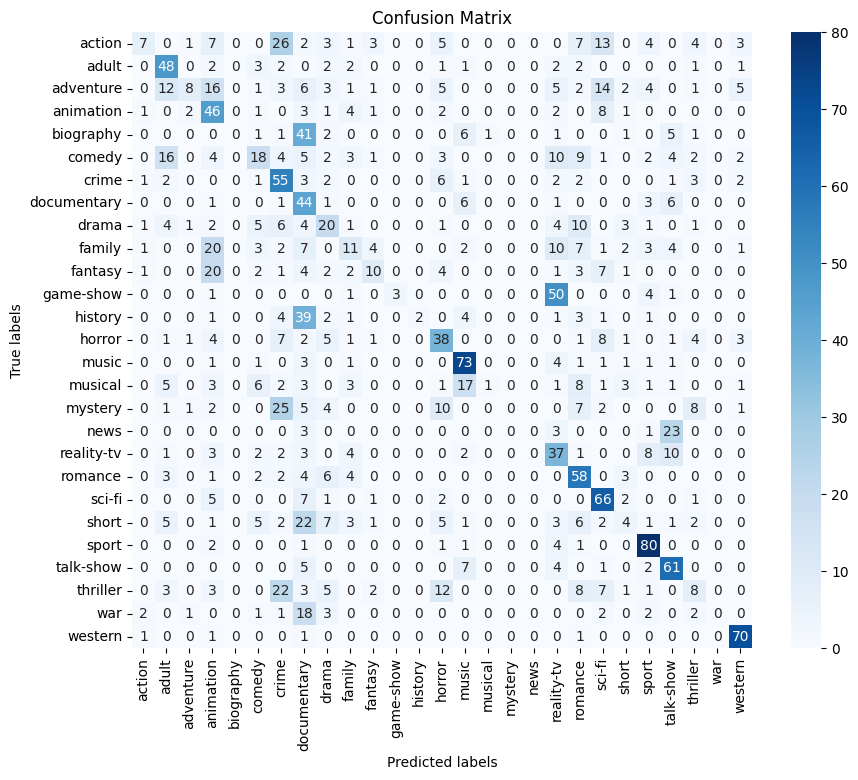

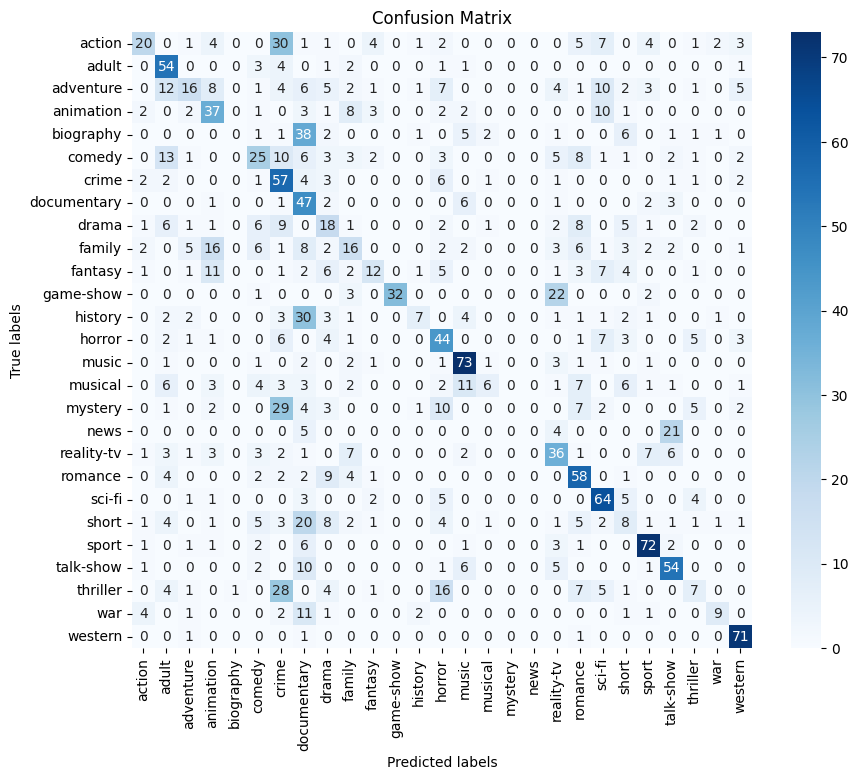

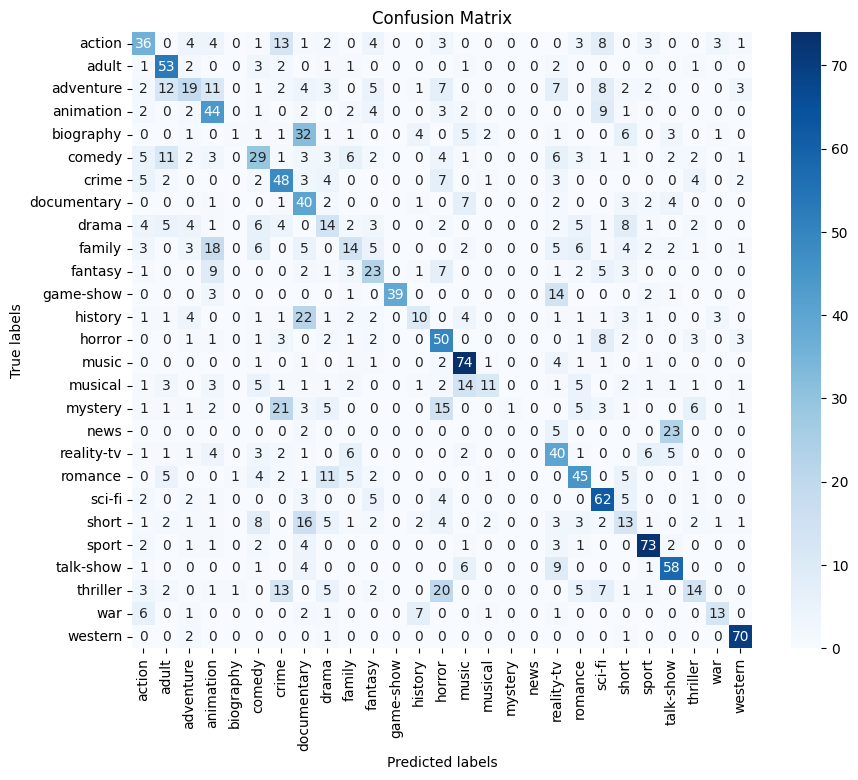

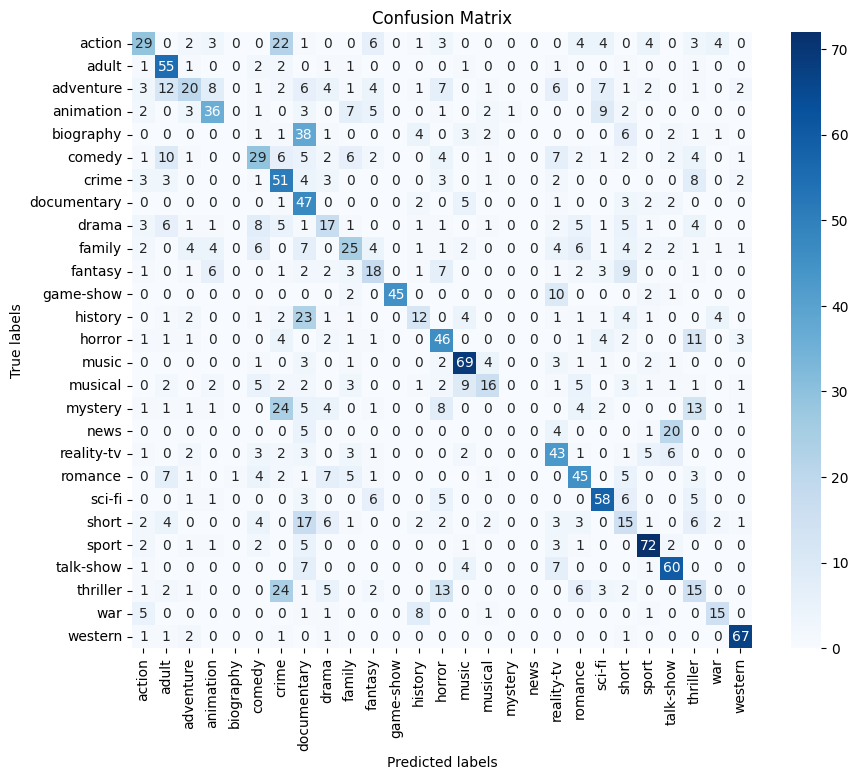

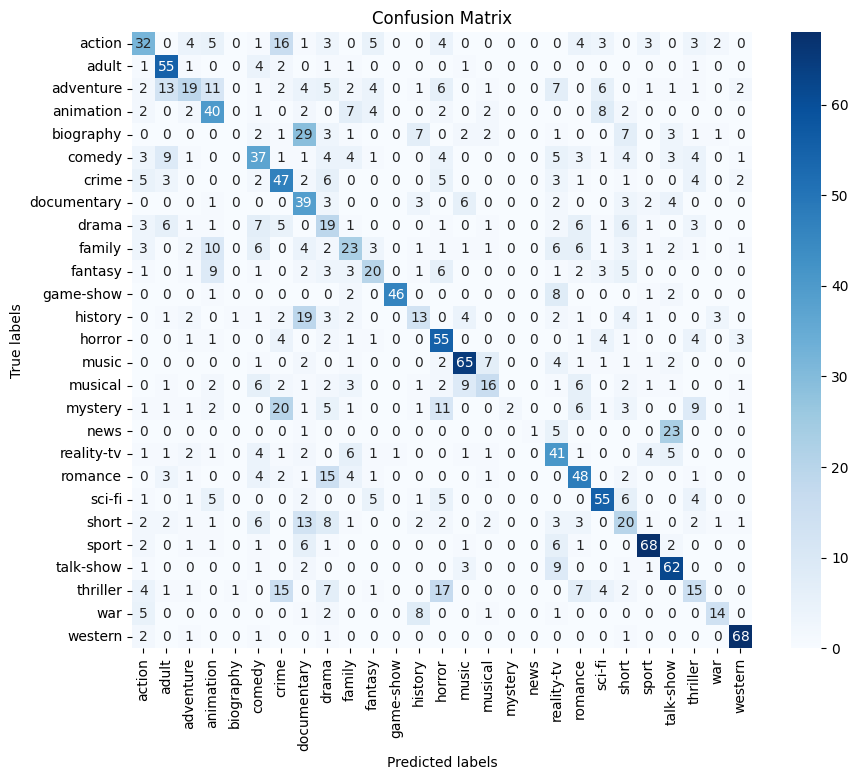

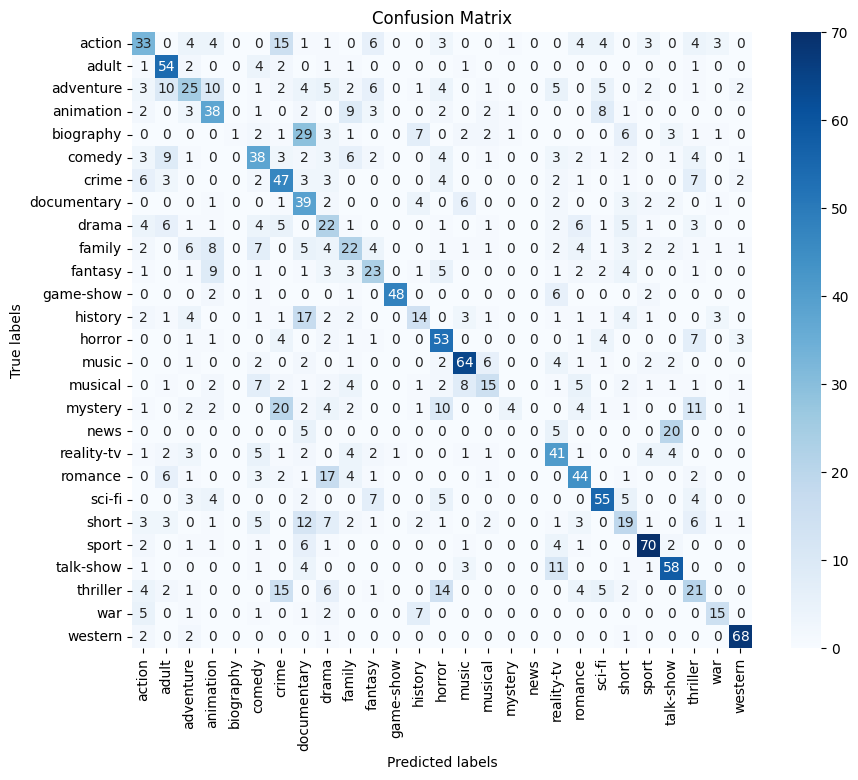

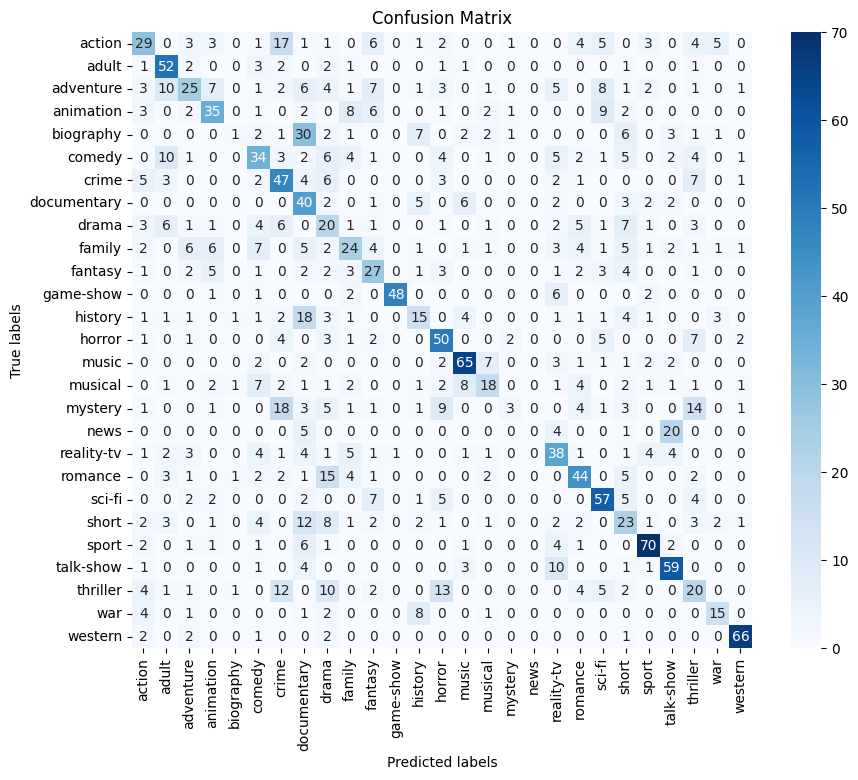

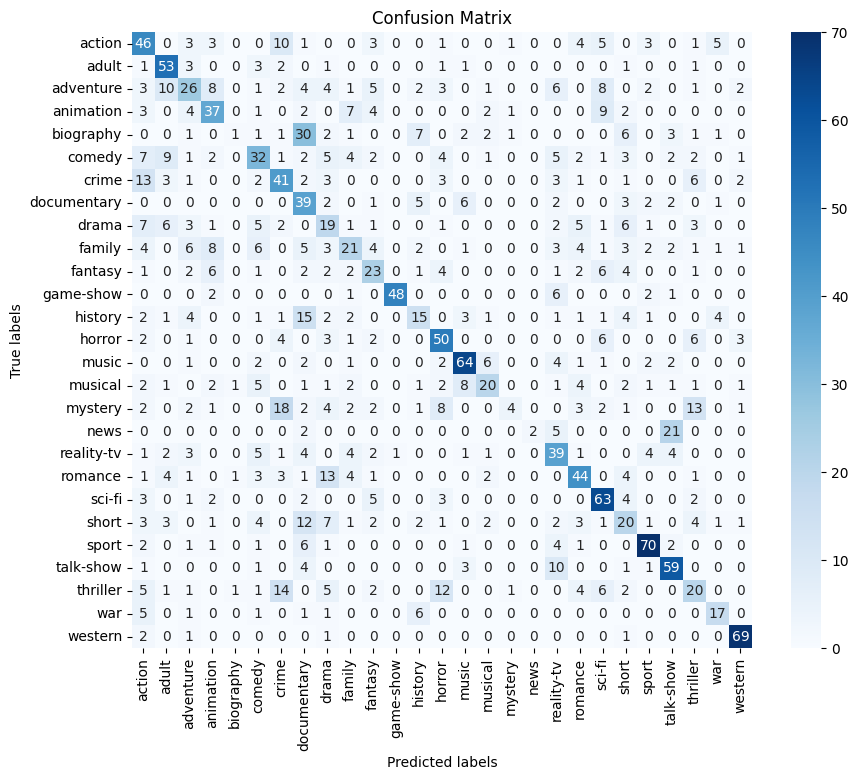

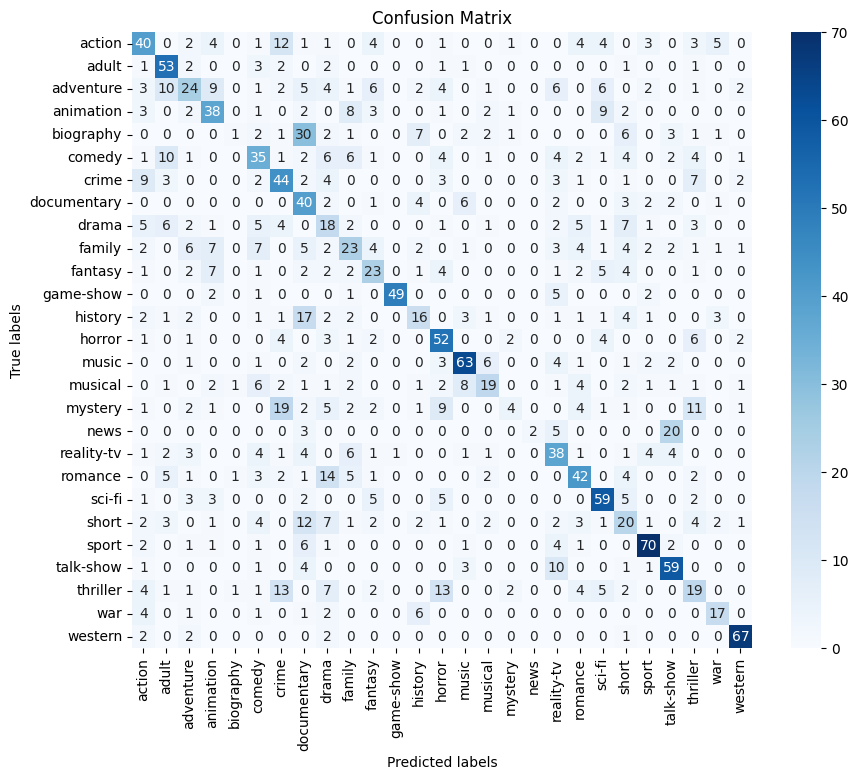

TrainOutput(global_step=900, training_loss=1.6575594764285617, metrics={'train_runtime': 1120.1137, 'train_samples_per_second': 51.022, 'train_steps_per_second': 0.803, 'total_flos': 7573887066470400.0, 'train_loss': 1.6575594764285617, 'epoch': 10.0})

In [28]:
trainer.train()


In [30]:
trainer.save_model("./genrepredict")


In [1]:
from transformers import pipeline

classifier = pipeline('text-classification', model='./genrepredict')

result = classifier("i will go to war")

predicted_label_id = result[0]['label']
predicted_score = result[0]['score']

actual_label = label_map[int(predicted_label_id.split('_')[1])]

print("Predicted label:", actual_label)
print("Confidence score:", predicted_score)


NameError: name 'label_map' is not defined

In [44]:
print("DistilBERT Training Accuracy:", accuracy_nb)

DistilBERT Training Accuracy: 0.7665354330708661
              precision    recall  f1-score   support

      action       0.88      0.83      0.86       311
       adult       0.96      0.93      0.95       302
   adventure       0.90      0.84      0.87       326
   animation       0.92      0.86      0.89       320
   biography       1.00      0.01      0.03       202
      comedy       0.95      0.84      0.89       318
       crime       0.83      0.92      0.87       315
 documentary       0.65      0.85      0.74       309
       drama       0.78      0.90      0.84       325
      family       0.93      0.79      0.86       311
     fantasy       0.98      0.46      0.63       261
   game-show       0.99      0.63      0.77       158
     history       1.00      0.03      0.05       195
      horror       0.73      0.96      0.83       318
       music       0.55      0.97      0.70       337
     musical       1.00      0.09      0.16       224
     mystery       1.00      0.3

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

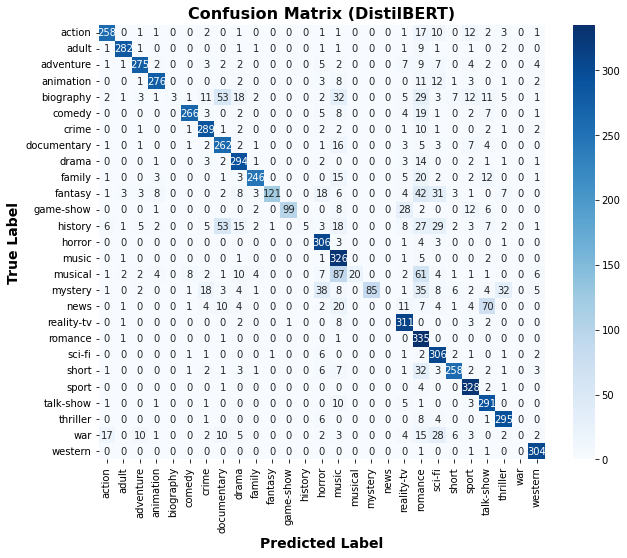

In [43]:
conf_matrix_nb_train = confusion_matrix(y_train, y_pred_nb)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_nb_train, annot=True, fmt='d', cmap='Blues', xticklabels=tuned_nb_classifier.classes_, yticklabels=tuned_nb_classifier.classes_)
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix (DistilBERT)', fontsize=16, fontweight='bold')
plt.show()


In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import numpy as np

model_name = "./genrepredict" 
model = AutoModelForSequenceClassification.from_pretrained(model_name)


tokenizer = AutoTokenizer.from_pretrained(model_name)


label_map = {
    0: 'action', 1: 'adult', 2: 'adventure', 3: 'animation', 4: 'biography', 5: 'comedy', 6: 'crime',
    7: 'documentary', 8: 'drama', 9: 'family', 10: 'fantasy', 11: 'game-show', 12: 'history', 13: 'horror',
    14: 'music', 15: 'musical', 16: 'mystery', 17: 'news', 18: 'reality-tv', 19: 'romance', 20: 'sci-fi',
    21: 'short', 22: 'sport', 23: 'talk-show', 24: 'thriller', 25: 'war', 26: 'western'
}


def classify_text(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    predicted_class_idx = torch.argmax(outputs.logits).item()
    predicted_class = label_map[predicted_class_idx]
    return predicted_class


example_text = "Amidst the chaos of battle, the deafening roar of gunfire echoed across the battlefield as troops advanced towards the enemy lines."

predicted_genre = classify_text(example_text)
print("Predicted Genre:", predicted_genre)

Predicted Genre: war
